# This notebook comprises code used to numerically generate the conduit network system observed at Bear Spring based on inputs (sinkholes), outputs (springs), and topographical/geologic properties of the area


Importing of necessary pacakges. Ensure that pyKasso, Karstnet are installed as a part of the same directory path

### Warning: the packages skfmm and scipy have cross compatability issues with the most recent version of numpy. In order to ensure compatability between these two packages, use version 1.23.4 of numpy and version 1.9.2 of scipy. (as of 10/27/22)

In [13]:
#Load all packages needed for pyKasso, Skffm, karstnet, agd Remannian metric
import sys
import os
import copy
import numpy
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import mplstereonet #Needed for karstnet
import karstnet as kn #karst network statistisc
# there appears to be an issue with skfmm and the current versioning of numpy installed
sys.path.append(r'C:\Users\csouc\Desktop\Bear Spring Data\Bear_Spring_Modeling')

#fast marching related imports
import skfmm #fast marching algorithm, solves eikonal problems along boundary conditions
import agd #adaptive grid discritization, discretizing anisotropic PDE on cartesian grid
from agd import Eikonal
from agd.Metrics import Riemann
import importlib as importlib
import yaml
os.getcwd()

'C:\\Users\\csouc\\Bear_Spring_pyKasso'

In [14]:
#Import the base package from pyKasso
sys.path.append(r'C:\Users\csouc\Desktop\Bear Spring Data\Bear_Spring_Modeling\pyKasso-replace-fast-marching-with-HFM\pyKasso-replace-fast-marching-with-HFM\pykasso')
import base as pk

importlib.reload(pk);
os.getcwd()

'C:\\Users\\csouc\\Bear_Spring_pyKasso'

In [15]:
#convert fracture TIFF to JPG (only needs to be done one time)
#from PIL import Image

#im = Image.open(r"C:\Users\csouc\Desktop\Bear Spring Data\Spatial Data\Area_A_Marion_aerial_imagery.tiff")
#im.save('fractureJPEG.jpg') #saved to the current working directory

In [16]:
#created the SKS class for the springshed model
#springshed = pk.SKS(r"C:\Users\csouc\Desktop\Bear Spring Data\Bear_Spring_Modeling\Bear_Spring_pyKasso\inputs\bear\settings.yaml")
springshed = pk.SKS(r"C:\Users\csouc\Bear_Spring_pyKasso\inputs\bear\settings_High_Res_3x3.yaml")

CAUTION: You are using the development version of this package.


Import catchment input data for a simple system, aka topography, geology, spring locations, sinkhole locations. **modifications to geology, topography, spring locations were hard coded into my .yaml file, but the process for modifying these is the same as seen below with the fracture update**

In [17]:
#resize fracture network image to be used in pykasso
from PIL import Image
fracture_image = Image.open(r"C:\Users\csouc\Bear_Spring_pyKasso\fracture_map.png")
frac_resized = fracture_image.resize((1210,931))
frac_resized.save('frac_resized.png')

#modifications to fractures from image
springshed.set_fractures_mode('image')
springshed.set_fractures_datafile(r'C:\Users\csouc\Bear_Spring_pyKasso\frac_resized.png')
springshed.update_fractures()

Access the .yaml file for each individual feature of the karst model and display them

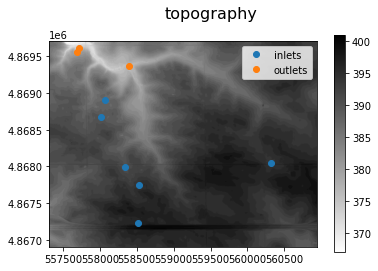

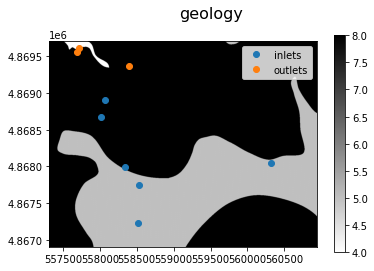

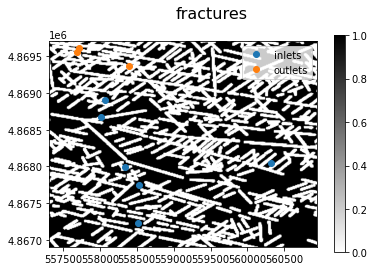

In [18]:
#display different aspects of the springshed model
topography = springshed.get_topography()
springshed.show_catchment(data='topography')
geology = springshed.get_geology()
springshed.show_catchment(data='geology')
fractures = springshed.get_fractures()
springshed.show_catchment(data='fractures')
springshed.set_data_has_polygon(False)
springshed.update_polygon()

-START-
Total Iteration 0 Outlet iteration: 0
	 Current outlet index: 0
	 Inlets assigned to this outlet:
           x          y  outlet   outletx    outlety  inlet_iteration
0  558070.0  4868904.0     0.0  557714.0  4869606.0                0
1  558517.0  4867238.0     0.0  557714.0  4869606.0                0
		 Inlet iteration: 0
          x          y  outlet   outletx    outlety  inlet_iteration
0  558070.0  4868904.0     0.0  557714.0  4869606.0                0
1  558517.0  4867238.0     0.0  557714.0  4869606.0                0
Field seedRadius defaults to 0
Field showProgress defaults to 0
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 0.904 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportActiveOffsets defaults to 0
Unused fields from compute : FMCPUTime GeodesicCPUTime

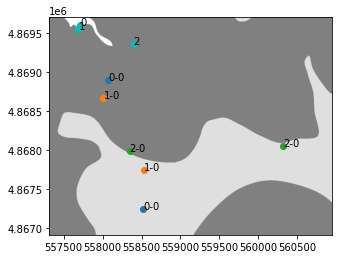

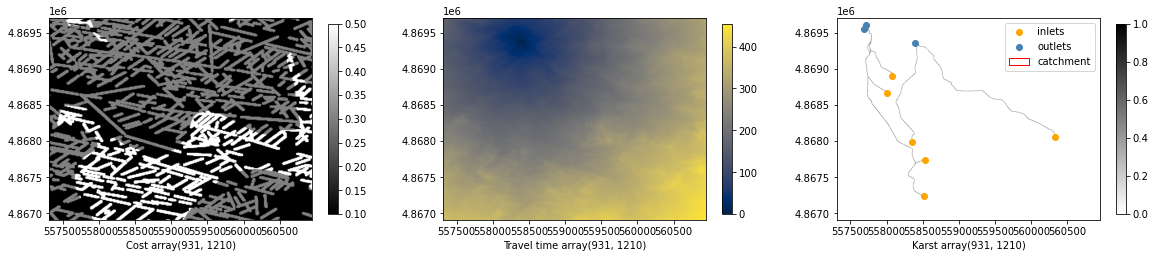

-START-
Total Iteration 0 Outlet iteration: 0
	 Current outlet index: 0
	 Inlets assigned to this outlet:
           x          y  outlet   outletx    outlety  inlet_iteration
0  558070.0  4868904.0     0.0  557714.0  4869606.0                0
1  558517.0  4867238.0     0.0  557714.0  4869606.0                0
		 Inlet iteration: 0
          x          y  outlet   outletx    outlety  inlet_iteration
0  558070.0  4868904.0     0.0  557714.0  4869606.0                0
1  558517.0  4867238.0     0.0  557714.0  4869606.0                0
Field seedRadius defaults to 0
Field showProgress defaults to 0
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 1.34 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportActiveOffsets defaults to 0
Unused fields from compute : FMCPUTime GeodesicCPUTime 

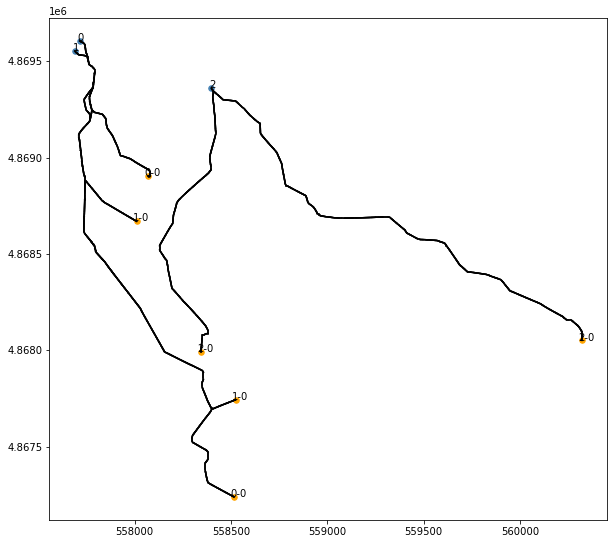

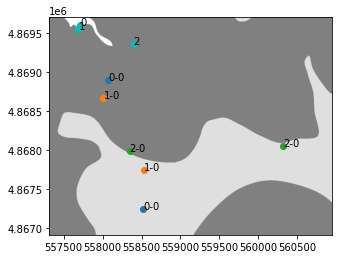

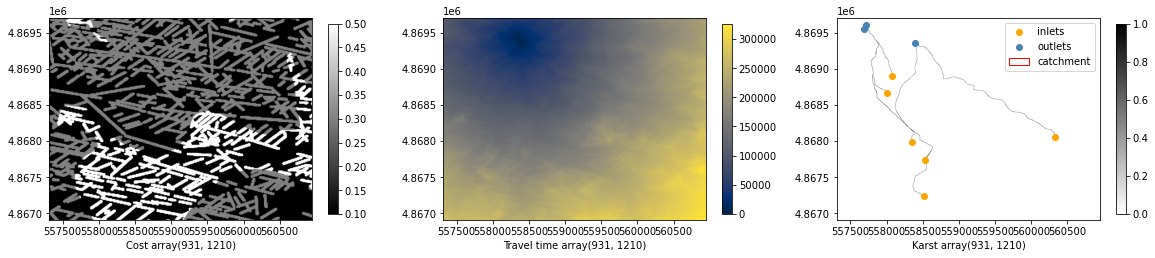

In [19]:
#compute the karst network
springshed.set_inlets_importance([6]) #how to iterate over inlets: length of array indicates number of inlet iterations,
#each integer indicates number of inlets to run in that iteration, sum of integers = total number of inlets

springshed.set_inlets_per_outlet([2,2,2])#how many inlets to assign to each outlet : length of array=number of outlets,
#each integer=number of inlets to assign to that outlet, sum of integers=total number of inlets

springshed.set_outlets_importance([1,1,1])#how to iterate over outlets: length of array indicates number of iterations, 
#each integer indicates number of outlets in that iteration, sum of integers = total number of outlets
#to run each outlet separately:              [1,1,1,...]  

springshed.set_verbosity(3)#Need to get clarification from Chloe on what this is exactly

#Travel cost through each feature (higher=slower/harder, will be avoided by conduits)
springshed.set_cost_aquifer(.3)
cost_aquifer = .3 #these adjustments of variable are to satisfy local variable requirements
springshed.set_cost_aquiclude(.5)
cost_aquiclude = .5
springshed.set_cost_fractures(.1)
cost_fractures = .1

springshed.set_orientation_mode('topo')
springshed.update_orientation()

#assigning geologic meaning to each of the raster dataset values
springshed.set_geology_id([4,5,8]) #creates an array of each of the values representing geologic units
springshed.set_geology_cost([cost_aquiclude, cost_aquiclude, cost_aquifer])#assigns the appropriate costs to each of the 
#indices in the geology id array created above 
#note that because all of our units are karstifiable we have set the stewartville to be a slightly less soluble aquifer
#(no true aquiclude) 

#Isotropic conduit network simulation
springshed.set_algorithm('Isotropic2')
springshed.compute_karst_network()
springshed.show()
springshed.show_network(data=springshed.karst_simulations[0], simplify=False, labels=['inlets','outlets'], plot_nodes=False, legend=False, color='k')

#anisotropic network simulation
springshed.set_data_has_polygon(False)
springshed.update_polygon()
springshed.set_algorithm('Riemann2')#set the appropriate fast marching algorithm, number refers to either 2D or 3D

springshed.update_all()#actually applies all of the above edits to the yaml file so that it can be used by the SKS class
springshed.compute_karst_network()#computes the karst network based on the features outlined in the .yaml file
springshed.show()#shows the computed karst network


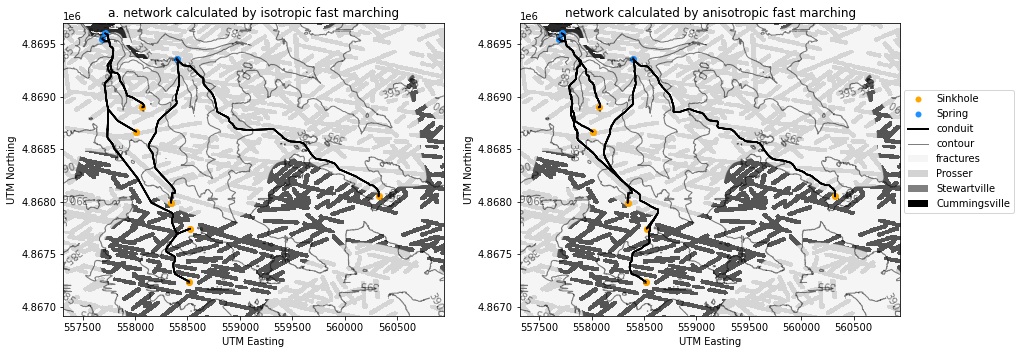

In [20]:
#Adjust the output images from the karstnetwork to be more viewable
f = plt.figure(figsize=(15,15))
cmap_frac = matplotlib.colors.ListedColormap(['whitesmoke']) #fractures will be off-white
cmap_frac.set_under(color='w', alpha=0)  #all values under range will be transparent
cmap_cond = matplotlib.colors.ListedColormap(['k']) #conduits will be black
cmap_cond.set_under(color='w', alpha=0) #all values under range will be transparent
frac = springshed.geology.data['fractures']['data'].copy() #get a copy of the fractures array
frac[frac<1] = -1        #replace all non-fracture cells with an out of bounds value to make them transparent

#Isotropic
##########
ax = f.add_subplot(121, aspect='equal')
ax.set_title('a. network calculated by isotropic fast marching')
plt.ylabel('UTM Northing')
plt.xlabel('UTM Easting')
plt.imshow(springshed.geology.data['geology']['data'], origin='lower', extent=springshed.grid.extent, cmap='gray', vmin=3,vmax=9)
plt.imshow(frac,                                      origin='lower', extent=springshed.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
c = plt.contour(springshed.grid.X,springshed.grid.Y, springshed.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)

springshed.show_network(ax=ax, data=springshed.karst_simulations[0], simplify=False, labels=[], plot_nodes=False, legend=False, color='k')

plt.scatter(springshed.inlets[:,0],  springshed.inlets[:,1],  c='orange')
plt.scatter(springshed.outlets[:,0], springshed.outlets[:,1], c='dodgerblue')

#Anisotropic
ax = f.add_subplot(122, aspect='equal')
ax.set_title('network calculated by anisotropic fast marching')
plt.ylabel('UTM Northing')
plt.xlabel('UTM Easting')
plt.imshow(springshed.geology.data['geology']['data'], origin='lower', extent = springshed.grid.extent, cmap='gray', vmin=3,vmax=9)

plt.imshow(frac,                                      origin='lower', extent=springshed.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
c = plt.contour(springshed.grid.X,springshed.grid.Y, springshed.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)

springshed.show_network(ax=ax, polygon=False, data=springshed.karst_simulations[1], simplify=False, labels=[], plot_nodes=False, legend=False, color='k')

plt.scatter(springshed.inlets[:,0],  springshed.inlets[:,1],  c='orange')
plt.scatter(springshed.outlets[:,0], springshed.outlets[:,1], c='dodgerblue')


#Legend
legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='orange', markeredgecolor='none', label='Sinkhole'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='Spring'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=2, alpha=1,   label='conduit'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=1, alpha=0.5, label='contour'),
          matplotlib.patches.Patch(facecolor='whitesmoke', label='fractures'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='Prosser'),
          matplotlib.patches.Patch(facecolor='gray',       label='Stewartville'),
          matplotlib.patches.Patch(facecolor='k',    label='Cummingsville')]
plt.legend(handles=legend, loc=[1.01,0.35]);

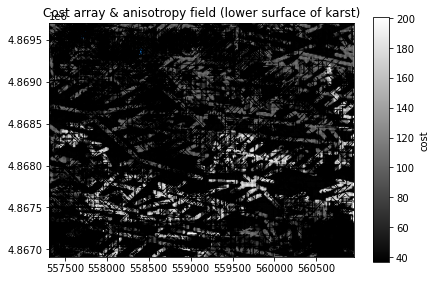

In [21]:
#cost and anisotropy

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121, aspect='equal')
ax.set_title('Cost array & anisotropy field (lower surface of karst)')

im = plt.imshow(springshed.maps['alpha'][0], origin='lower', extent=springshed.grid.extent, cmap='gray')
plt.scatter(springshed.outlets[:,0], springshed.outlets[:,1], c='dodgerblue')
skip = (slice(None,None,5), slice(None,None,5))
q=plt.quiver(springshed.grid.X[skip], springshed.grid.Y[skip],
            -1*springshed.geology.data['orientationy']['data'][skip], -1*springshed.geology.data['orientationx']['data'][skip], scale=4)

plt.colorbar(im, aspect=15, shrink=0.3, label='cost')

-START-
Total Iteration 0 Outlet iteration: 0
	 Current outlet index: 0
	 Inlets assigned to this outlet:
           x          y  outlet   outletx    outlety  inlet_iteration
0  558070.0  4868904.0     0.0  557714.0  4869606.0                0
1  558517.0  4867238.0     0.0  557714.0  4869606.0                0
		 Inlet iteration: 0
          x          y  outlet   outletx    outlety  inlet_iteration
0  558070.0  4868904.0     0.0  557714.0  4869606.0                0
1  558517.0  4867238.0     0.0  557714.0  4869606.0                0
Field seedRadius defaults to 0
Field showProgress defaults to 0
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 1.335 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportActiveOffsets defaults to 0
Unused fields from compute : FMCPUTime GeodesicCPUTime

{'mean length': 68.21738430532106,
 'cv length': 4.12725487550076,
 'length entropy': 0.11024877688576905,
 'tortuosity': 1.0541601945431358,
 'orientation entropy': 0.9068871082711686,
 'aspl': 27.14549436795995,
 'cpd': 0.2985251798561152,
 'mean degree': 2.524822695035461,
 'cv degree': 0.2660338416547517,
 'correlation vertex degree': -0.44973275642657173}

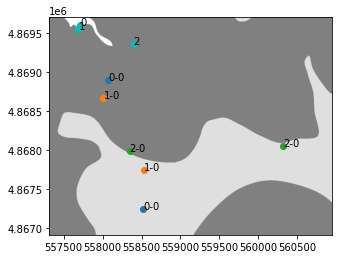

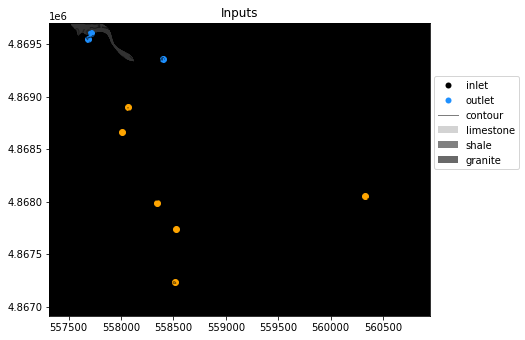

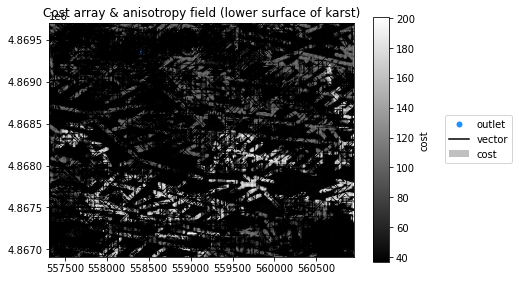

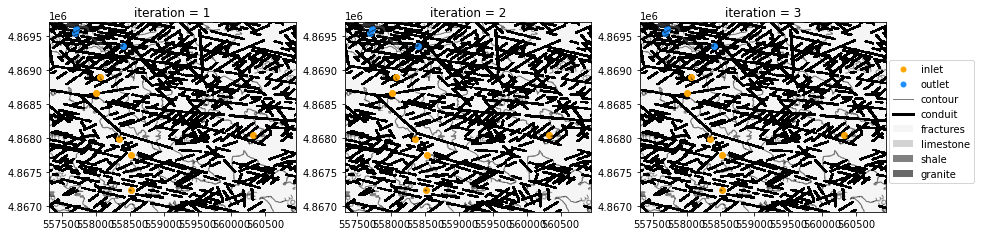

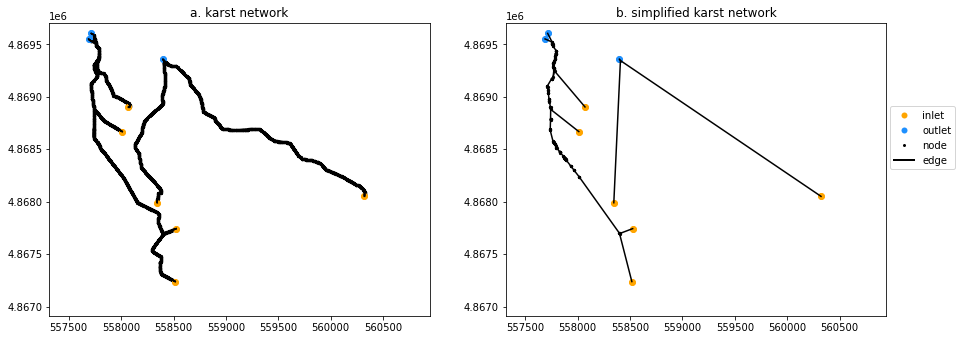

In [22]:
#Reload & update model with appropriate settings:
springshed.set_inlets_importance([1])             #assign the first two inlets to the first outlet, and the remaining three inlets to the second outlet
springshed.set_outlets_shuffle(True)
springshed.set_algorithm('Riemann2')                  #set the fast-marching algorithm (Riemann is one version of an anisotropic algorith, 2 indicates 2D)
springshed.set_orientation_mode('topo')            #use the lower surface of the karst unit as the anisotropy field
springshed.update_orientation()                       #update model
springshed.compute_karst_network()                    #run the model to generate the karst network

#Inputs
###############
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121, aspect='equal')
ax.set_title('Inputs')

plt.imshow(springshed.geology.data['geology']['data'], origin='lower', extent=springshed.grid.extent, cmap='gray_r', vmin=0,vmax=5)
c = plt.contour(springshed.grid.X,springshed.grid.Y, springshed.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
plt.scatter(springshed.inlets[:,0],  springshed.inlets[:,1],  c='orange')
plt.scatter(springshed.outlets[:,0], springshed.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=1, alpha=0.5, label='contour'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',       label='shale'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='granite')]
plt.legend(handles=legend, loc=[1.01,0.5])


#cost and anisotropy

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121, aspect='equal')
ax.set_title('Cost array & anisotropy field (lower surface of karst)')

im = plt.imshow(springshed.maps['alpha'][0], origin='lower', extent=springshed.grid.extent, cmap='gray')
plt.scatter(springshed.outlets[:,0], springshed.outlets[:,1], c='dodgerblue')
skip = (slice(None,None,5), slice(None,None,5))
q=plt.quiver(springshed.grid.X[skip], springshed.grid.Y[skip],
            -1*springshed.geology.data['orientationy']['data'][skip], -1*springshed.geology.data['orientationx']['data'][skip], scale=4)

plt.colorbar(im, aspect=15, shrink=0.3, label='cost')
legend = [matplotlib.lines.Line2D([0], [0], marker='o',  color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], marker=None, color='k', label='vector'),
          matplotlib.patches.Patch(facecolor='silver',   label='cost')]
plt.legend(handles=legend, loc=[1.3,0.4])

#Inlet iteration
f = plt.figure(figsize=(15,15))

frac = springshed.geology.data['fractures']['data'].copy() #get a copy of the fractures array
frac[frac<1] = -1                                         #replace all non-fracture cells with an out of bounds value to make them transparent
cond = springshed.maps['karst'].copy()                     #get a copy of the karst array
cond = cond.astype('int')                                 #convert to integers to be able to manipulate
cond[cond<1] = -1                                         #replace all non-conduit cells with an out of bounds value to make them transparent

ax = f.add_subplot(131, aspect='equal')
ax.set_title('iteration = 1')
plt.imshow(springshed.geology.data['geology']['data'], origin='lower', extent=springshed.grid.extent, cmap='gray_r', vmin=0,vmax=5)
plt.imshow(frac,                                      origin='lower', extent=springshed.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
plt.imshow(cond[0],                                   origin='lower', extent=springshed.grid.extent, cmap=cmap_cond,    vmin=0,vmax=1)
c = plt.contour(springshed.grid.X,springshed.grid.Y, springshed.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
plt.scatter(springshed.inlets[:,0],  springshed.inlets[:,1],  c='orange')
plt.scatter(springshed.outlets[:,0], springshed.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(132, aspect='equal')
ax.set_title('iteration = 2')
plt.imshow(springshed.geology.data['geology']['data'], origin='lower', extent=springshed.grid.extent, cmap='gray_r', vmin=0,vmax=5)
plt.imshow(frac,                                      origin='lower', extent=springshed.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
plt.imshow(cond[1],                                   origin='lower', extent=springshed.grid.extent, cmap=cmap_cond,    vmin=0,vmax=1)
c = plt.contour(springshed.grid.X,springshed.grid.Y, springshed.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
plt.scatter(springshed.inlets[:,0],  springshed.inlets[:,1],  c='orange')
plt.scatter(springshed.outlets[:,0], springshed.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(133, aspect='equal')
ax.set_title('iteration = 3')
plt.imshow(springshed.geology.data['geology']['data'], origin='lower', extent=springshed.grid.extent, cmap='gray_r', vmin=0,vmax=5)
plt.imshow(frac,                                      origin='lower', extent=springshed.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
plt.imshow(cond[2],                                   origin='lower', extent=springshed.grid.extent, cmap=cmap_cond,    vmin=0,vmax=1)
c = plt.contour(springshed.grid.X,springshed.grid.Y, springshed.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
plt.scatter(springshed.inlets[:,0],  springshed.inlets[:,1],  c='orange')
plt.scatter(springshed.outlets[:,0], springshed.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='orange', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=1, alpha=0.5, label='contour'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=3,            label='conduit'),
          matplotlib.patches.Patch(facecolor='whitesmoke', label='fractures'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',       label='shale'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='granite')]
plt.legend(handles=legend, loc=[1.01,0.15])

#Outputs: network, simplified network, and table of statistics.
###############
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121, aspect='equal')
ax.set_title('a. karst network')

plt.imshow(springshed.maps['outlets'], origin='lower', extent=springshed.grid.extent, cmap='gray_r', vmin=0,vmax=0)
springshed.show_network(ax=ax, data=springshed.karst_simulations[0], simplify=False, labels=[], plot_nodes=True, legend=False, color='k')
plt.scatter(springshed.inlets[:,0],  springshed.inlets[:,1],  c='orange')
plt.scatter(springshed.outlets[:,0], springshed.outlets[:,1], c='dodgerblue')

ax = f.add_subplot(122, aspect='equal')
ax.set_title('b. simplified karst network')

plt.imshow(springshed.maps['outlets'], origin='lower', extent=springshed.grid.extent, cmap='gray_r', vmin=0,vmax=0)
springshed.show_network(ax=ax, data=springshed.karst_simulations[0], simplify=True, labels=[], plot_nodes=True, legend=False, color='k')
plt.scatter(springshed.inlets[:,0],  springshed.inlets[:,1],  c='orange')
plt.scatter(springshed.outlets[:,0], springshed.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='orange', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], marker='.', color='none', markerfacecolor='k', markeredgecolor='none', label='node'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=2, label='edge')]
plt.legend(handles=legend, loc=[1.01,0.5])

print('\n Network statistics:')
springshed.karst_simulations[0].stats

-START-
Total Iteration 0 Outlet iteration: 0
	 Current outlet index: 0
	 Inlets assigned to this outlet:
           x          y  outlet   outletx    outlety  inlet_iteration
0  558070.0  4868904.0     0.0  557714.0  4869606.0                0
1  558517.0  4867238.0     0.0  557714.0  4869606.0                0
		 Inlet iteration: 0
          x          y  outlet   outletx    outlety  inlet_iteration
0  558070.0  4868904.0     0.0  557714.0  4869606.0                0
1  558517.0  4867238.0     0.0  557714.0  4869606.0                0
Field seedRadius defaults to 0
Field showProgress defaults to 0
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 1.355 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportActiveOffsets defaults to 0
Unused fields from compute : FMCPUTime GeodesicCPUTime

Field seedRadius defaults to 0
Field showProgress defaults to 0
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 1.383 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportActiveOffsets defaults to 0
Unused fields from compute : FMCPUTime GeodesicCPUTime MaxStencilWidth StencilCPUTime geodesicFlow geodesicLengths geodesicPoints nAccepted values 
Defaulted fields : exportActiveNeighs exportActiveOffsets geodesicSolver geodesicStep geodesicVolumeBound geodesicWeightThreshold refineStencilAtWallBoundary seedRadius showProgress 
Visited but unset fields : activeNeighs costVariation dualMetric euclideanScale factoringRadius factoringValues getStencils indexToPoint inspectSensitivity keyHelp nMaxAccepted pointToIndex progressReportLandmarks seedFlags seedValueVariation seedValues stopAtDistan

Field seedRadius defaults to 0
Field showProgress defaults to 0
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 1.373 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportActiveOffsets defaults to 0
Unused fields from compute : FMCPUTime GeodesicCPUTime MaxStencilWidth StencilCPUTime geodesicFlow geodesicLengths geodesicPoints nAccepted values 
Defaulted fields : exportActiveNeighs exportActiveOffsets geodesicSolver geodesicStep geodesicVolumeBound geodesicWeightThreshold refineStencilAtWallBoundary seedRadius showProgress 
Visited but unset fields : activeNeighs costVariation dualMetric euclideanScale factoringRadius factoringValues getStencils indexToPoint inspectSensitivity keyHelp nMaxAccepted pointToIndex progressReportLandmarks seedFlags seedValueVariation seedValues stopAtDistan


Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd
-START-
Total Iteration 0 Outlet iteration: 0
	 Current outlet index: 0
	 Inlets assigned to this outlet:
           x          y  outlet   outletx    outlety  inlet_iteration
0  558070.0  4868904.0     0.0  557714.0  4869606.0                0
1  558517.0  4867238.0     0.0  557714.0  4869606.0                0
		 Inlet iteration: 0
          x          y  outlet   outletx    outlety  inlet_iteration
0  558070.0  4868904.0     0.0  557714.0  4869606.0                0
1  558517.0  4867238.0     0.0  557714.0  4869606.0                0
Field seedRadius defaults to 0
Field showProgress defaults to 0
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 1.365 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActi

Field seedRadius defaults to 0
Field showProgress defaults to 0
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 1.397 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportActiveOffsets defaults to 0
Unused fields from compute : FMCPUTime GeodesicCPUTime MaxStencilWidth StencilCPUTime geodesicFlow geodesicLengths geodesicPoints nAccepted values 
Defaulted fields : exportActiveNeighs exportActiveOffsets geodesicSolver geodesicStep geodesicVolumeBound geodesicWeightThreshold refineStencilAtWallBoundary seedRadius showProgress 
Visited but unset fields : activeNeighs costVariation dualMetric euclideanScale factoringRadius factoringValues getStencils indexToPoint inspectSensitivity keyHelp nMaxAccepted pointToIndex progressReportLandmarks seedFlags seedValueVariation seedValues stopAtDistan

Field seedRadius defaults to 0
Field showProgress defaults to 0
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 1.382 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportActiveOffsets defaults to 0
Unused fields from compute : FMCPUTime GeodesicCPUTime MaxStencilWidth StencilCPUTime geodesicFlow geodesicLengths geodesicPoints nAccepted values 
Defaulted fields : exportActiveNeighs exportActiveOffsets geodesicSolver geodesicStep geodesicVolumeBound geodesicWeightThreshold refineStencilAtWallBoundary seedRadius showProgress 
Visited but unset fields : activeNeighs costVariation dualMetric euclideanScale factoringRadius factoringValues getStencils indexToPoint inspectSensitivity keyHelp nMaxAccepted pointToIndex progressReportLandmarks seedFlags seedValueVariation seedValues stopAtDistan


Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


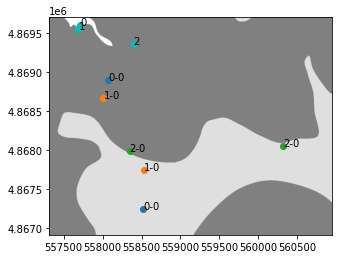

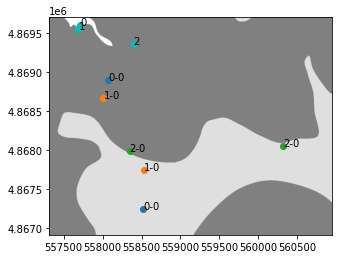

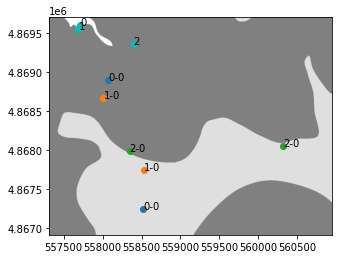

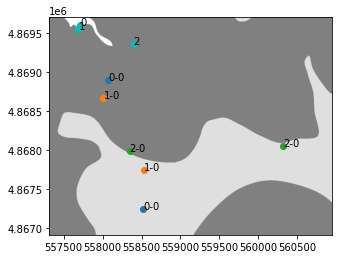

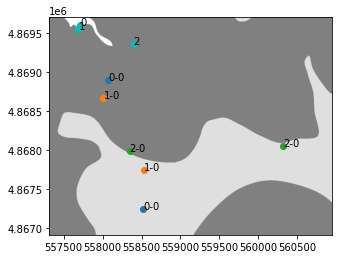

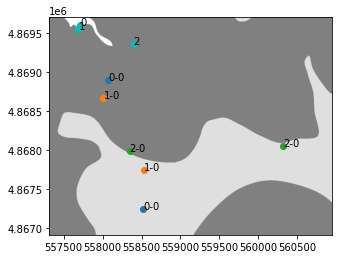

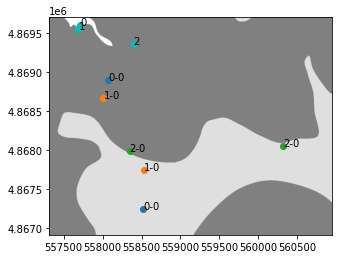

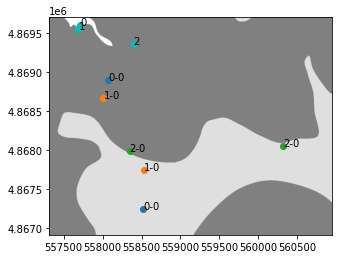

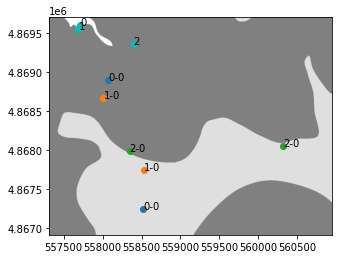

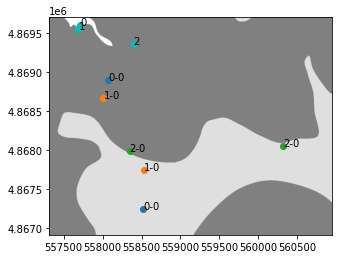

In [23]:

n = 10                                      #number of iterations to calculate (caution: more than 10 is slow)
for i in range(n):
    springshed.update_inlets()
    springshed.update_fractures()
    springshed.compute_karst_network() 

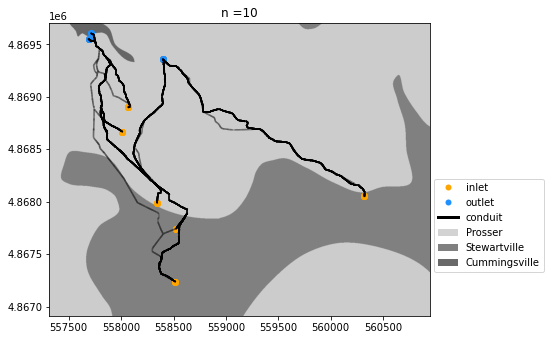

In [24]:
#Many iterations:
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(121, aspect='equal')
ax.set_title('n ='+str(n))
plt.imshow(springshed.geology.data['geology']['data'], origin='lower', extent=springshed.grid.extent, cmap='gray', vmin=0, vmax=10)
#plt.imshow(springshed._compute_average_paths(), origin='lower', extent=springshed.grid.extent, cmap='gray_r')
for i in range(n):
    springshed.show_network(ax=ax, data=springshed.karst_simulations[i], simplify=False, labels=[], plot_nodes=False, legend=False, color='k', alpha=1/n)

plt.scatter(springshed.inlets[:,0],  springshed.inlets[:,1],  c='orange')
plt.scatter(springshed.outlets[:,0], springshed.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='orange', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=3,            label='conduit'),
          matplotlib.patches.Patch(facecolor='lightgray',  label='Prosser'),
          matplotlib.patches.Patch(facecolor='gray',       label='Stewartville'),
          matplotlib.patches.Patch(facecolor='dimgray',    label='Cummingsville')]
plt.legend(handles=legend, loc=[1.01,0.15])